# Examples' Choice

## Setup

### Imports

In [1]:
from pathlib import Path
import json
import pandas as pd
from tqdm import tqdm
import os
from PIL import Image
from pycocotools import mask as mask_utils
import random
# set seed
random.seed(0)

### Directories

Place the images' folder and the annotations. in `data/raw`, keep the LVIS filenames.

In [2]:
DATA_DIR = Path.cwd() / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
IMAGES_DIR = RAW_DATA_DIR / "train2017"

### Read Data

In [3]:
with open(RAW_DATA_DIR / "lvis_v1_train.json") as f:
    data = json.load(f)

In [4]:
cat_imgs_anns = {}
imgs_cat_anns = {}

for annotation in tqdm(data["annotations"]):
    cat_id = annotation["category_id"]
    img_id = annotation["image_id"]
    id = annotation["id"]
    if cat_id not in cat_imgs_anns:
        cat_imgs_anns[cat_id] = {}
    if img_id not in imgs_cat_anns:
        imgs_cat_anns[img_id] = {}
    if img_id not in cat_imgs_anns[cat_id]:
        cat_imgs_anns[cat_id][img_id] = []
    if cat_id not in imgs_cat_anns[img_id]: 
        imgs_cat_anns[img_id][cat_id] = []
    cat_imgs_anns[cat_id][img_id].append(annotation)
    imgs_cat_anns[img_id][cat_id].append(annotation)

  0%|          | 0/1270141 [00:00<?, ?it/s]

100%|██████████| 1270141/1270141 [00:02<00:00, 563669.84it/s]


Use `cat_imgs_anns` to access images and annotations by category id.
Use `img_cats_anns` to access categories and annotations by image id.

In [5]:
def get_pil_image(img_data):
    img_name = os.path.basename(img_data["coco_url"])
    img_path = IMAGES_DIR / img_name
    return Image.open(img_path)

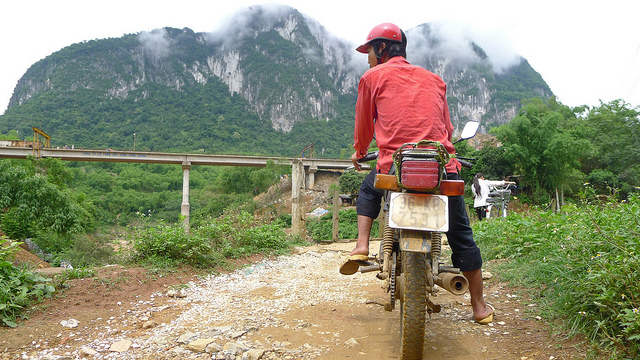

In [6]:
img_data = data["images"][0]
get_pil_image(img_data)

## Convert Annotations

LVIS uses polygons to represent masks. We convert them to RLE data format and then to binary masks, using the official LVIS API code.

In [7]:
def ann_to_rle(ann, h, w):
    """Convert annotation which can be polygons, to RLE.

    Args:
        ann (dict): annotation object
        h (int): image height
        w (int): image width
    """
    segm = ann["segmentation"]
    if isinstance(segm, list):
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = mask_utils.frPyObjects(segm, h, w)
        rle = mask_utils.merge(rles)
    elif isinstance(segm["counts"], list):
        # uncompressed RLE
        rle = mask_utils.frPyObjects(segm, h, w)
    else:
        # rle
        rle = ann["segmentation"]
    return rle

def ann_to_mask(ann, h, w):
    """Convert annotation which can be polygons, uncompressed RLE, or RLE
    to binary mask.
    Args:
        ann (dict) : annotation object
        h (int): image height
        w (int): image width

    Returns:
        binary mask (numpy 2D array)
    """
    rle = ann_to_rle(ann, h, w)
    return mask_utils.decode(rle)

## Show Segmentation

In [12]:
import numpy as np
import cv2

def draw_masks(image_data, cats=None):
    image = np.array(get_pil_image(image_data))
    masked_image = image.copy()

    colors = {}
    for cat in imgs_cat_anns[image_data["id"]]:
        colors[cat] = np.random.randint(0, 255, size=(3,)).tolist()

    masks = {}
    for cat in imgs_cat_anns[image_data["id"]]:
        masks[cat] = []
        for ann in imgs_cat_anns[image_data["id"]][cat]:
            masks[cat].append(ann_to_mask(ann, image_data["height"], image_data["width"]))

    for cat in masks:
        if cats is None or cat in cats:
            for mask in masks[cat]:
                masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                        np.asarray(colors[cat], dtype='uint8'),
                                        masked_image)

    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)

In [13]:
segmented_image = draw_masks(image_data=data["images"][2])


import plotly.express as px
fig = px.imshow(segmented_image)
fig.show()

## Examples' Choice

In [15]:
# select a query image and take its annotations
query_image = data["images"][6]
query_image_anns = imgs_cat_anns[query_image["id"]]

In [16]:
# set M (no. of examples to present)
M = 5

In [18]:
# take random int from 1 to len(query_image_anns) - which corresponds to number of categories in the image
C = random.randint(1, len(query_image_anns))
# take random C categories from query_image_anns
C_categories = random.sample(list(query_image_anns.keys()), min(M, C))
C_categories

[836, 160, 1188, 430]

In [19]:
# partition C_categories into M sets (with replacement if necessary)
sublists = []

while len(C_categories) > 0:
    sublist_size = random.randint(1, len(C_categories))
    sublist = C_categories[:sublist_size]
    sublists.append(sublist)
    C_categories = C_categories[sublist_size:]

sublists = sublists[:M]
sublists

[[836, 160], [1188, 430]]

Now, each list inside `sublists` represents a set of categories that will be used to find images that contain all of them. The images are chosen randomly.

In [21]:
# for a sublist of categories, get all image ids that contain all categories in the sublist
# except for the query image id
def get_image_ids_intersection(sublist, query_image_id):
    possible_examples = []
    for cat in sublist:
        possible_examples.append(set())
        for image_id in cat_imgs_anns[cat]:
            if image_id != query_image_id:
                possible_examples[-1].add(image_id)
    return set.intersection(*possible_examples)

In [22]:
M_examples = []
M_classes = []

for sublist in sublists:
    intersection = get_image_ids_intersection(sublist, query_image["id"])
    
    while not intersection:
        # if there are no images that contain all categories in the sublist
        # remove the last category from the sublist and try again
        sublist = sublist[:-1]
        intersection = get_image_ids_intersection(sublist, query_image["id"])
    
    M_examples.append(intersection)
    M_classes.append(sublist)

In [23]:
# for each sublist (set of categories), take a random image from the intersection
M_base_examples = [random.choice(list(cat_examples)) for cat_examples in M_examples]

# if there are less than M examples, add more examples from the same categories
# so that at the end there are M examples, and each sublist is represented by at least one example
while len(M_base_examples) < M:
    x = random.randint(0, len(M_examples) - 1)
    M_base_examples.append(random.choice(list(M_examples[x])))
    M_classes.append(M_classes[x])

In [32]:
for example_id, class_ids in zip(M_base_examples, M_classes):
    print (example_id, "will be segmented with classes: ", class_ids)

425569 will be segmented with classes:  [836, 160]
301837 will be segmented with classes:  [1188, 430]
128076 will be segmented with classes:  [1188, 430]
301837 will be segmented with classes:  [1188, 430]
183218 will be segmented with classes:  [836, 160]


## Show Results

In [33]:
def get_image_by_id(image_id):
    for image in data["images"]:
        if image["id"] == image_id:
            return image
def get_cat_by_id(cat_id):
    for cat in data["categories"]:
        if cat["id"] == cat_id:
            return cat["name"]

In [36]:
# show query image and M base examples
example_images = [get_image_by_id(x) for x in M_base_examples]
example_images.append(query_image)

segmented_images = [draw_masks(image_data=image, cats=[x for y in sublists for x in y]) for image in example_images]

for idx, image in enumerate(segmented_images):
    fig = px.imshow(image)
    title = []
    if idx < len(M_classes):
        for cat in M_classes[idx]:
            title.append(get_cat_by_id(cat))
    else:
        title.append("Query Image")
        query_classes = [get_cat_by_id(x) for y in sublists for x in y]
        title += query_classes
    fig.update_layout(title=", ".join(title))
    fig.show()

## Pasquale

In [1]:
from pathlib import Path
import random
import torch
import json
from tqdm import tqdm
import plotly.express as px
# set seed
random.seed(0)

In [2]:
DATA_DIR = Path.cwd() / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
IMAGES_DIR = RAW_DATA_DIR / "train2017"

---

In [ ]:
with open(RAW_DATA_DIR / "lvis_v1_train.json") as f:
    data = json.load(f)

In [7]:
annotations = data["annotations"]
id2category = {elem['id']: elem['name'] for elem in data['categories']}

In [10]:
new_json = {
    'categories': data['categories'],
    'annotations': [{k:v for k , v in elem.items() if k in ['image_id', 'category_id']} for elem in annotations],
}

In [ ]:
with open("categories.json", "w") as f:
    json.dump(new_json, f)

If you already have it

In [5]:
with open(RAW_DATA_DIR / "categories.json") as f:
    data = json.load(f)

In [6]:
annotations = data["annotations"]
id2category = {elem['id']: elem['name'] for elem in data['categories']}

In [7]:
len(annotations)

1270141

In [8]:
# {image_id: categories_set} building
# {category_id: images_set} building

image_categories = {}
category_images = {}

for annotation in tqdm(annotations):
    image_id = annotation['image_id']
    category_id = annotation['category_id']
    if image_id not in image_categories:
        image_categories[image_id] = set()
    image_categories[image_id].add(category_id)
    if category_id not in category_images:
        category_images[category_id] = set()
    category_images[category_id].add(image_id)

100%|██████████| 1270141/1270141 [00:01<00:00, 866200.37it/s]


In [7]:
cat_distribution = [len(image_categories[image_id]) for image_id in image_categories]

In [8]:
px.histogram(cat_distribution, nbins=50)

In [9]:
from label_anything.data.examples import generate_examples, sample_power_law, sample_classes_from_query, generate_examples_power_law_uniform

%reload_ext autoreload
%autoreload 2

In [12]:
ALPHA = -1
MIN_SIZE = 2

query = annotations[torch.randint(0, len(annotations) - 1, (1,)).item()]

query_categories = torch.tensor(list(set(image_categories[query['image_id']])), dtype=torch.int64)

print(f"Classes        : {[id2category[cat_id.item()] for cat_id in query_categories]}")

sampled_images, sampled_classes = generate_examples_power_law_uniform(query, query_categories, category_images, 5) 
print(f"Sampled classes: {[id2category[cat_id] for cat_id in sampled_classes]}")

Classes        : ['kite']


AttributeError: 'list' object has no attribute 'tolist'

In [13]:
sample_min_size = 1
def selection_strategy(images, category_to_images, example_sampled_classes):
    # Uniform
    return random.choice(list(images))
M = 10
generate_examples(query['image_id'], sampled_classes, category_images, sample_min_size, power_law, selection_strategy, M)

({12895,
  63777,
  213596,
  244616,
  340185,
  353711,
  423114,
  449256,
  460405,
  546985,
  559051},
 [{496, 653},
  {653},
  {496},
  {496, 653},
  {496, 653},
  {496},
  {653},
  {496, 653},
  {496, 653},
  {496, 653}],
 0.0,
 0.32222222222222224)